## ADCP

- Estação Amostral:	ADP - P14
- Latitude:	-27.253183
- Longitude:	-48.401215
- Datum:	SIRGAS-2000
- Declinação Magnética	corrigida


- Intervalo de Amostragem:	60 minutos
- Tempo de Amostragem:	5 minutos
- Taxa de Aquisição Interna:	1000 kHz


- Início da Série Temporal:	3/30/2014 12:00
- Término da Série Temporal:	7/2/2015 10:00
- Total [dias]	458.92


- Equipamento	ADP - Sontek
- Marca	Sontek
- Nº de Série	M1327

In [1]:
import pandas as pd


def read_sheet(fname, sheet_name):
    df = pd.read_excel(
        fname,
        sheet_name=sheet_name,
        skiprows=20,
        na_values=-999.0,
    ).dropna(axis=1, how="all")
    index = pd.to_datetime(
        {
            "year": df["Ano"],
            "month": df["Mes"],
            "day": df["Dia"],
            "hour": df["Hora"],
        },
    )
    df.index = index
    return df.drop(["Ano", "Mes", "Dia", "Hora"], axis=1)

In [2]:
import folium


location = [-27.253183, -48.401215]

m = folium.Map(location=location, zoom_start=11)
folium.Marker(location=location).add_to(m)
m

In [3]:
import pooch


url = f"https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/Dados_brutos_Maare_2016_HDM.xlsx",
    known_hash="sha256:e8a25896e0e4c09e214639547fd6c09f9065b4b61738e36ae126de0431a85249",
)

In [4]:
adp = read_sheet(fname, sheet_name="Corrente")
ele = read_sheet(fname, sheet_name="Nivel_Temp")

df = pd.concat([ele, adp], axis=1)
# not sure but those look like local time UTC-3
df.index = df.index + pd.DateOffset(hours=3)

In [5]:
import utide


time = df.index.to_numpy()
u, v = df["U01(m/s)"].to_numpy(), df["V01(m/s)"].to_numpy()

In [6]:
coef = utide.solve(
    time,
    u, v,
    lat=-27.253183,
    method="robust",
    conf_int="MC",
    verbose=False,
)

In [7]:
def make_table_uv(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["Lsmaj"] = coef["Lsmaj"]
    summary["Lsmaj_ci"] = coef["Lsmaj_ci"]
    summary["Lsmin"] = coef["Lsmin"]
    summary["Lsmin_ci"] = coef["Lsmin_ci"]
    summary["theta"] = coef["theta"]
    summary["theta_ci"] = coef["theta_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="Lsmaj", ascending=False)


summary = make_table_uv(coef)

In [8]:
summary

,PE,SNR,frq,Lsmaj,Lsmaj_ci,Lsmin,Lsmin_ci,theta,theta_ci,g,g_ci
name,,,,,,,,,,,
M2,42.906020,9513.223581,0.080511,0.053504,0.000844,0.017490,0.000753,124.092370,1.091629,31.212453,1.040270
S2,18.181628,4281.723348,0.083333,0.034665,0.000722,0.011877,0.000827,133.544002,1.731285,41.864948,1.935378
M4,7.693720,5107.597318,0.161023,0.023518,0.000509,-0.003886,0.000411,134.292421,0.920246,191.117893,1.274223
SA,4.644722,43.273432,0.000114,0.018169,0.004123,-0.003593,0.003667,56.938195,12.698211,80.352953,11.980720
S1,3.931720,352.008646,0.041667,0.014682,0.001227,0.008649,0.001289,168.528894,10.542608,167.921964,10.327026
...,...,...,...,...,...,...,...,...,...,...,...
EPS2,0.019490,4.132075,0.076177,0.000915,0.000738,-0.000775,0.000891,67.269563,103.169628,327.609885,97.355050
3MK7,0.011065,27.518632,0.283315,0.000847,0.000227,-0.000316,0.000251,26.336129,21.192973,259.558493,21.527349
OQ2,0.009671,2.801334,0.075975,0.000842,0.000740,0.000069,0.000657,60.205627,70.389383,225.429255,61.659579


In [9]:
from utide import reconstruct


tide = reconstruct(time, coef)

prep/calcs ... done.


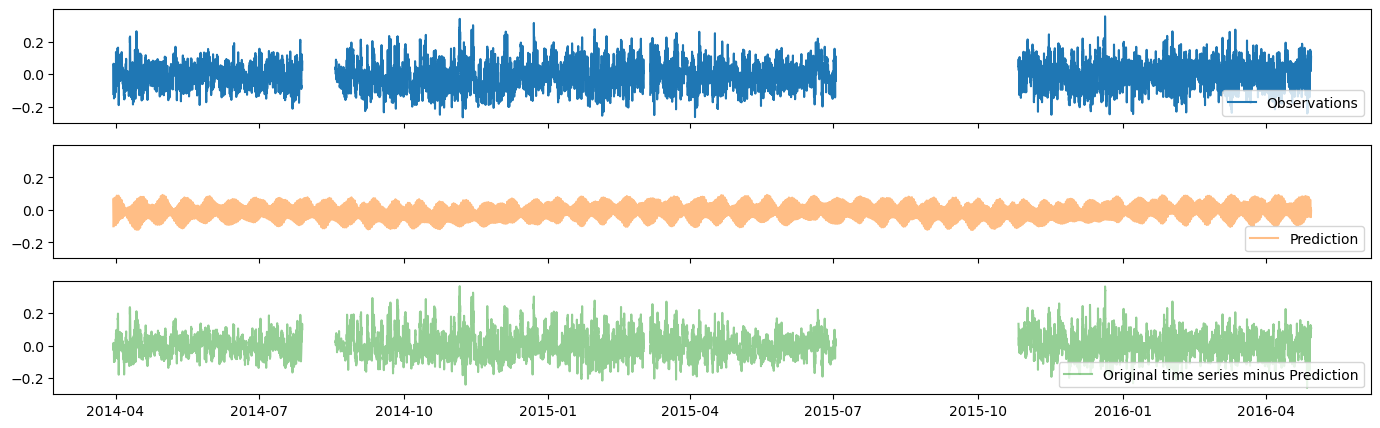

In [10]:
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, u, label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(time, tide["u"], alpha=0.5, label="Prediction", color="C1")
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(time, u-tide["u"], alpha=0.5, label="Original time series minus Prediction", color="C2")
ax2.legend(numpoints=1, loc="lower right");

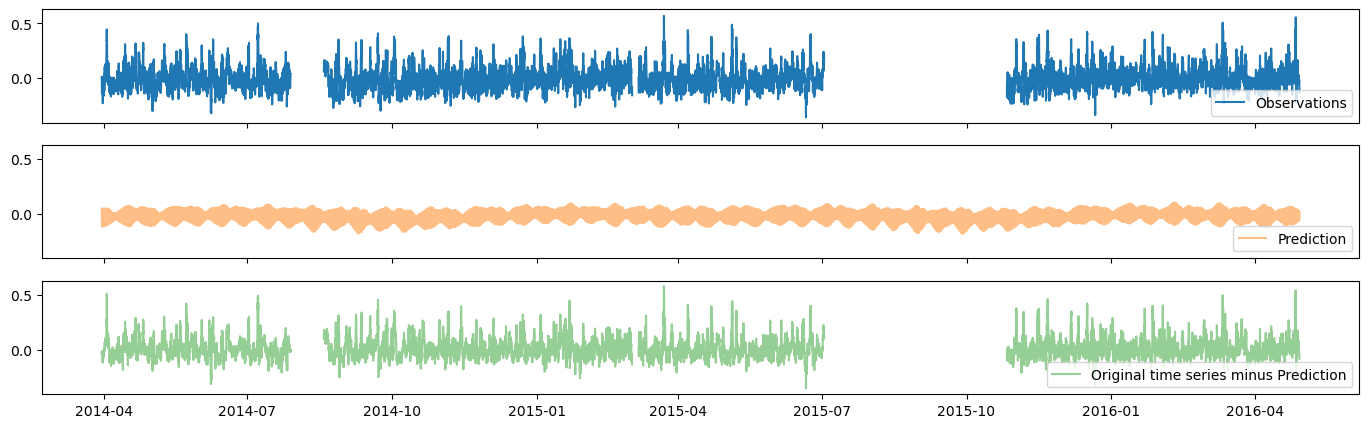

In [11]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, v, label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(time, tide["v"], alpha=0.5, label="Prediction", color="C1")
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(time, v-tide["v"], alpha=0.5, label="Original time series minus Prediction", color="C2")
ax2.legend(numpoints=1, loc="lower right");

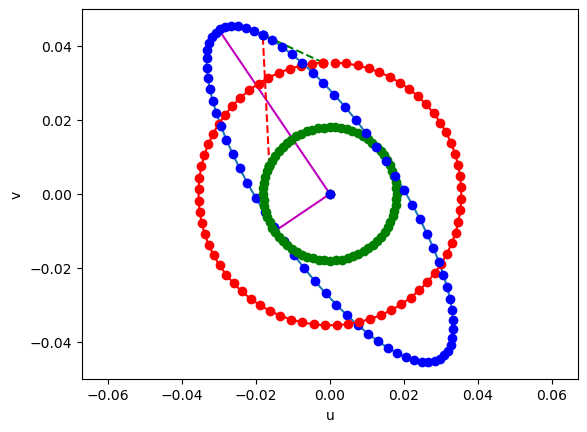

In [12]:
import tidal_ellipse


const = summary.loc["M2"]

SEMA, SEMI = const["Lsmaj"], const["Lsmin"]
PHA, INC = const["g"], const["theta"]
ECC = SEMI / SEMA

tidal_ellipse.do_the_plot(SEMA, ECC, INC, PHA)